<h1>Introduction</h1>

Moving to a new city for  job and finding a neighbourhood with all aminities, population, transport connectivity is hard. In this clustering analysis, we will hypothasis a problem where we will be analysing the neighbourhood around Bellandur [mostly southern and eastern part of banglore] and find a safe and good neighbourhood to move into by leveraging location data from Foursquare


<h4>Importing required libraries </h4>

In [65]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json

import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<h4> Data Gathering </h4>

Since we dont have information about bangalore neighbourhood readiliy availble, we will be web scraping the data from wikipedia, we will be using BeautifulSoup's libraries to extract the required data from wikipedia webpage and convert them to Pandas dataframe for our analysis.

In [6]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore'
wiki_res = requests.get(wiki_url).text

In [7]:
soup = BeautifulSoup(wiki_res,'lxml')
#print(soup.prettify())

In [8]:
tblData = soup.find_all('table',{'class':'wikitable sortable'})
print(len(tblData))
heads = soup.find_all('span', {'class':'mw-headline'})

master = []
for i in range(len(heads[:8])):
    print(heads[i].text)
    
    table_rows = tblData[i].find_all('tr')
    
    for tr in table_rows:
        td = tr.find_all('td')
        row = [heads[i].text]+ [tr.text.rstrip("\n") for tr in td]
        master.append(row)
        
blore = pd.DataFrame(master, columns=['Brough','Neighbourhood', 'PostalCode', 'Description']).dropna()

8
Central
Eastern
North-Eastern
Northern
South-Eastern
Southern
Southern suburbs
Western


In [9]:
blore.head(10)

,Brough,Neighbourhood,PostalCode,Description
1,Central,Cantonment area,,The Cantonment area in Bangalore was used as a...
2,Central,Domlur,,"Formerly part of the Cantonment area, Domlur h..."
3,Central,Indiranagar,,Indiranagar is a sought-after residential and ...
4,Central,Jeevanbheemanagar,,
5,Central,Malleswaram,,
6,Central,Pete area,,Established by Kempe Gowda I at the time of cr...
7,Central,Sadashivanagar,,Sadashivanagar is an upscale neighbourhood in ...
8,Central,Seshadripuram,,Seshadripuram was established in 1892 to reduc...
9,Central,Shivajinagar,,Shivajinagar is one of the older areas of the ...
10,Central,Ulsoor,,Ulsoor (or Halasuru) is one of the oldest area...


In [10]:
blore['Brough'].value_counts()

Central             11
Western             10
Eastern              8
Southern             8
Northern             8
South-Eastern        7
North-Eastern        7
Southern suburbs     6
Name: Brough, dtype: int64

In [11]:
blore.columns

Index(['Brough', 'Neighbourhood', 'PostalCode', 'Description'], dtype='object')

<h4>Data Selection </h4>
    
The office location is situated near Bellandur, We are going to consider only the brough around Bellandur [~15km tops] like, Central, Eastern, South-Eastern, Southern broughs of Banglore. So we are subsetting the dataframe craeted by scraping wikipedia to contain only the broughs from Central, Easters, southern and south eastern.

We wont require PostalCode and Description column so deleting it.


In [12]:
blore_brough = blore[blore['Brough'].isin(['Central','Eastern','Southern','South-Eastern'])]
del blore_brough['PostalCode'], blore_brough['Description']

There are 50+ neighbourhood options available to move-in. Interesting.

In [13]:
blore_brough['Brough'].value_counts()
blore_brough['Neighbourhood']

1        Cantonment area
2                 Domlur
3            Indiranagar
4      Jeevanbheemanagar
5            Malleswaram
6              Pete area
7         Sadashivanagar
8          Seshadripuram
9           Shivajinagar
10                Ulsoor
11         Vasanth Nagar
13             Bellandur
14        CV Raman Nagar
15                 Hoodi
16      Krishnarajapuram
17          Mahadevapura
18          Marathahalli
19               Varthur
20            Whitefield
39          Bommanahalli
40           Bommasandra
41            BTM Layout
42       Electronic City
43            HSR Layout
44           Koramangala
45              Madiwala
47          Banashankari
48          Basavanagudi
49             Girinagar
50           J. P. Nagar
51             Jayanagar
52    Kumaraswamy Layout
53       Padmanabhanagar
54           Uttarahalli
Name: Neighbourhood, dtype: object

<h4> Data Preprovessing </h4>
We dont have latitude and longitude information for these neighbourhoods, we are using Google's Geocoding API to get latlong information for our neighbourhood.

In [15]:
API_KEY = '' #YOUR API KEY

In [16]:
def getLatLong(API_KEY, query1):
    
    gurl = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(requests.compat.quote_plus(query1), API_KEY)
    #print(gurl)
    response = requests.get(gurl)
    resp_dict = json.loads(response.text)
    latlong = resp_dict['results'][0]['geometry']['location']
    print(query1, latlong)
    return latlong

def attachLatLong(row):
    query = row['Neighbourhood'] + ', Bangalore'
    latlong = getLatLong(API_KEY, query)
    #rint(query, latlong)
    row['latitude'] = latlong['lat']
    row['longitude'] = latlong['lng']
    
    return row

In [17]:
blore_brough = blore_brough.apply(attachLatLong, axis = 1) 

Cantonment area, Bangalore {'lat': 12.9937707, 'lng': 77.59778680000001}
Cantonment area, Bangalore {'lat': 12.9937707, 'lng': 77.59778680000001}
Domlur, Bangalore {'lat': 12.9609857, 'lng': 77.6387316}
Indiranagar, Bangalore {'lat': 12.9783692, 'lng': 77.6408356}
Jeevanbheemanagar, Bangalore {'lat': 12.964163, 'lng': 77.658076}
Malleswaram, Bangalore {'lat': 13.0055113, 'lng': 77.5692358}
Pete area, Bangalore {'lat': 12.9737096, 'lng': 77.5759122}
Sadashivanagar, Bangalore {'lat': 13.0068182, 'lng': 77.5812849}
Seshadripuram, Bangalore {'lat': 12.9889055, 'lng': 77.574044}
Shivajinagar, Bangalore {'lat': 12.9856503, 'lng': 77.60569269999999}
Ulsoor, Bangalore {'lat': 12.9817001, 'lng': 77.62841519999999}
Vasanth Nagar, Bangalore {'lat': 12.9896194, 'lng': 77.5927948}
Bellandur, Bangalore {'lat': 12.9304278, 'lng': 77.678404}
CV Raman Nagar, Bangalore {'lat': 12.9793254, 'lng': 77.6641841}
Hoodi, Bangalore {'lat': 12.9895552, 'lng': 77.71265710000002}
Krishnarajapuram, Bangalore {'lat'

In [18]:
blore_brough.head()

,Brough,Neighbourhood,latitude,longitude
1,Central,Cantonment area,12.993771,77.597787
2,Central,Domlur,12.960986,77.638732
3,Central,Indiranagar,12.978369,77.640836
4,Central,Jeevanbheemanagar,12.964163,77.658076
5,Central,Malleswaram,13.005511,77.569236


Now that we have attached latitude and longitude informations for the neighbourhood, lets plot them over bangalore map and see where these neighbourhoods located. We will be using Folium library to create Bangalore map and plot these coordinates on them.

In [19]:
address = 'Bangalore, Karnataka'

geolocator = Nominatim(user_agent="in_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

# create map of New York using latitude and longitude values
blore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(blore_brough['latitude'], blore_brough['longitude'], blore_brough['Brough'], blore_brough['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(blore)  
    
blore

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


<h4> Another method to get LatLong coordinates </h4>

In [ ]:
address = 'Domlur, Bangalore, Karnataka'

geolocator = Nominatim(user_agent="in_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Domlur are {}, {}.'.format(latitude, longitude))


<h4> Getting all the venues for each neighbourhood </h4>
Lets findout what are all the venues are in and around these neighbourhood. We will be using Foursquare API to get available commercial venues, parks, gyms etc.

In [70]:
CLIENT_ID = 'YOUR CLIENT KEY'
CLIENT_SECRET = 'YOUR SECRET KEY'
VERSION = '20200625' # Foursquare API version

print('Credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Credentails:
CLIENT_ID: YOUR CLIENT KEY
CLIENT_SECRET:YOUR SECRET KEY


In [21]:
# explore venues in Central Torornto per neigborhood
def getNearbyVenues(names, latitudes, longitudes, radius=750, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
blore_venues = getNearbyVenues(names=blore_brough['Neighbourhood'],
                                         latitudes=blore_brough['latitude'],
                                         longitudes=blore_brough['longitude']
                                         )

Cantonment area
Domlur
Indiranagar
Jeevanbheemanagar
Malleswaram
Pete area
Sadashivanagar
Seshadripuram
Shivajinagar
Ulsoor
Vasanth Nagar
Bellandur
CV Raman Nagar
Hoodi
Krishnarajapuram
Mahadevapura
Marathahalli
Varthur
Whitefield
Bommanahalli
Bommasandra
BTM Layout
Electronic City
HSR Layout
Koramangala
Madiwala
Banashankari
Basavanagudi
Girinagar
J. P. Nagar
Jayanagar
Kumaraswamy Layout
Padmanabhanagar
Uttarahalli


In [23]:
blore_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,12.993771,77.597787,Ujwal Bar & Restaurant,12.992280,77.594473,Indian Restaurant
1,Cantonment area,12.993771,77.597787,Millers 46,12.991666,77.594207,Steakhouse
2,Cantonment area,12.993771,77.597787,Alliance Française,12.991232,77.596723,Concert Hall
3,Cantonment area,12.993771,77.597787,Jayamahal Palace Hotel,12.996839,77.597163,Indian Restaurant
4,Cantonment area,12.993771,77.597787,Watson's,12.994218,77.594645,Pub


In [24]:
blore_venues.shape

(965, 7)

We have got around 965 venues around these neighbourhood.

In [27]:
grouped = blore_venues.groupby('Neighbourhood').count().reset_index()
#grouped.sort_values('Venue', ascending=False)
#blore_venues.groupby('Neighbourhood').count()
grouped

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BTM Layout,52,52,52,52,52,52
1,Banashankari,17,17,17,17,17,17
2,Basavanagudi,28,28,28,28,28,28
3,Bellandur,36,36,36,36,36,36
4,Bommanahalli,4,4,4,4,4,4
5,Bommasandra,1,1,1,1,1,1
6,CV Raman Nagar,9,9,9,9,9,9
7,Cantonment area,31,31,31,31,31,31
8,Domlur,44,44,44,44,44,44
9,Electronic City,29,29,29,29,29,29


In [28]:
blore_venues.to_csv('foursq_data.csv', index = False)

In [29]:
print('There are {} uniques categories.'.format(len(blore_venues['Venue Category'].unique())))

There are 144 uniques categories.


<h4>Data Exploration</h4>
Now that we have the required data for our analysis, lets explore these neighbourhood data. We are performing onehot encoding to findout the most common venues across neighbourhoods.

In [30]:
# one hot encoding
blore_onehot = pd.get_dummies(blore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
blore_onehot['Neighbourhood'] = blore_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [blore_onehot.columns[-1]] + list(blore_onehot.columns[:-1])
blore_onehot = blore_onehot[fixed_columns]

blore_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,...,Swiss Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
blore_grouped = blore_onehot.groupby('Neighbourhood').mean().reset_index()
blore_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,...,Swiss Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Turkish Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Women's Store,Yoga Studio
0,BTM Layout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019231,0.000000,0.00,...,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000
1,Banashankari,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Basavanagudi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035714,0.035714,0.00,...,0.000000,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Bellandur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bommanahalli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Bommasandra,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,CV Raman Nagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Cantonment area,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000
8,Domlur,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000
9,Electronic City,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103448,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<h4> Returning most common venue in decending order and 25 most common venues </h4>

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 25

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = blore_grouped['Neighbourhood']

for ind in np.arange(blore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(blore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,BTM Layout,Indian Restaurant,Coffee Shop,Snack Place,Bakery,Vegetarian / Vegan Restaurant,Ice Cream Shop,Chinese Restaurant,Café,Pizza Place,...,Food Court,Park,Italian Restaurant,Bus Line,Dim Sum Restaurant,Tea Room,Asian Restaurant,Dumpling Restaurant,Dessert Shop,Gastropub
1,Banashankari,Pizza Place,Clothing Store,Café,Fast Food Restaurant,Breakfast Spot,Indian Restaurant,North Indian Restaurant,Electronics Store,Miscellaneous Shop,...,German Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Convenience Store,Dumpling Restaurant,Eastern European Restaurant,General Entertainment,Event Space
2,Basavanagudi,Indian Restaurant,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Farmers Market,Hookah Bar,Asian Restaurant,Tea Room,Athletics & Sports,...,Eastern European Restaurant,Yoga Studio,Donut Shop,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Cupcake Shop,Diner,Fishing Store
3,Bellandur,Indian Restaurant,Hotel,Café,Fast Food Restaurant,Pizza Place,Lounge,Cafeteria,Bakery,Sandwich Place,...,Hotel Bar,Badminton Court,Tea Room,Gym,Multiplex,Eastern European Restaurant,Diner,Donut Shop,Dim Sum Restaurant,Dessert Shop
4,Bommanahalli,Indian Restaurant,Auto Garage,Department Store,Donut Shop,Fast Food Restaurant,Farmers Market,Event Space,Electronics Store,Eastern European Restaurant,...,Deli / Bodega,Cupcake Shop,Convenience Store,Field,Flea Market,Coffee Shop,Food,Food & Drink Shop,Food Court,Food Truck


<h4>Clustring</h4>
We are going to perform the clustering on the top 25 venues we prepared in previous step

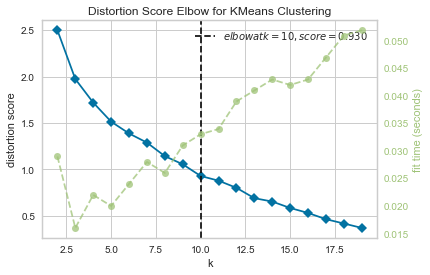

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB44AB1FD0>,
         k=None, locate_elbow=True, metric='distortion', model=None,
         timings=True)

In [50]:
blore_grouped_clustering = blore_grouped.drop('Neighbourhood', 1)

kelbow_visualizer(KMeans(random_state=0), blore_grouped_clustering, k=(2,20))

Using Elbow method, we found that the optimum clusters that can be created from this data is 4.

In [51]:
# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(blore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 7, 2, 5, 0, 5, 0])

In [53]:
# add clustering labels
del neighborhoods_venues_sorted['Cluster Labels'] 
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

blore_merged = blore_brough

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
blore_merged = blore_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

blore_merged.head() # check the last columns!

,Brough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
1,Central,Cantonment area,12.993771,77.597787,0,Indian Restaurant,Italian Restaurant,Salad Place,Chinese Restaurant,Music Venue,...,Fast Food Restaurant,Concert Hall,Steakhouse,Hotel,Tea Room,Furniture / Home Store,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Badminton Court,Bakery
2,Central,Domlur,12.960986,77.638732,5,Indian Restaurant,Café,Coffee Shop,Italian Restaurant,Pizza Place,...,Karnataka Restaurant,Hotel,BBQ Joint,Food,Food & Drink Shop,Nightclub,Multiplex,Convenience Store,Gaming Cafe,Vietnamese Restaurant
3,Central,Indiranagar,12.978369,77.640836,0,Indian Restaurant,Café,Pub,Bar,Chinese Restaurant,...,Fast Food Restaurant,Cocktail Bar,Mobile Phone Shop,Mexican Restaurant,Middle Eastern Restaurant,Butcher,Brewery,Outlet Store,Electronics Store,Karnataka Restaurant
4,Central,Jeevanbheemanagar,12.964163,77.658076,6,Indian Restaurant,Fast Food Restaurant,Pizza Place,Restaurant,Kerala Restaurant,...,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Deli / Bodega,Yoga Studio,Field,Farmers Market,Convenience Store
5,Central,Malleswaram,13.005511,77.569236,0,Indian Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Coffee Shop,South Indian Restaurant,...,American Restaurant,French Restaurant,Dumpling Restaurant,Convenience Store,Cupcake Shop,Golf Course,Deli / Bodega,German Restaurant,General Entertainment,Gastropub


Lets plot the clusters on the map

In [60]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**12 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow[2] = '#1D3159'
#print(rainbow)
rainbow = ['#D66853', '#7D4E57', '#364156','#212D40','#11151C', '#003265', '#0061A7', '#FDAD01', '#FC611C', '#CD3952']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(blore_merged['latitude'], blore_merged['longitude'], blore_merged['Neighbourhood'], blore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.Marker([12.937162,77.695193], popup='Office').add_to(map_clusters)
       
map_clusters

In [57]:
blore_grped = blore_merged.groupby(['Cluster Labels'], as_index = False).count()
blore_grped

,Cluster Labels,Brough,Neighbourhood,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
0,0,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
1,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
2,2,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
6,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
7,7,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,8,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,9,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


<h4> Result </h4>
From the above clustering results, we see that cluster 0,1,5 and 6 are having most common aminities in its neighbourhood and we can further explore these neighbourhood and find a house movein.

<h4>Cluster 0</h4>

In [68]:
c0 = blore_merged[blore_merged['Cluster Labels'] == 0]
c0

,Brough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
1,Central,Cantonment area,12.993771,77.597787,0,Indian Restaurant,Italian Restaurant,Salad Place,Chinese Restaurant,Music Venue,Mediterranean Restaurant,Café,Department Store,Pizza Place,Pool Hall,Pub,Juice Bar,Event Space,Coffee Shop,Sandwich Place,Fast Food Restaurant,Concert Hall,Steakhouse,Hotel,Tea Room,Furniture / Home Store,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Badminton Court,Bakery
3,Central,Indiranagar,12.978369,77.640836,0,Indian Restaurant,Café,Pub,Bar,Chinese Restaurant,Bakery,Dessert Shop,Department Store,Andhra Restaurant,Boutique,Lounge,Ice Cream Shop,Pizza Place,Punjabi Restaurant,Burger Joint,Fast Food Restaurant,Cocktail Bar,Mobile Phone Shop,Mexican Restaurant,Middle Eastern Restaurant,Butcher,Brewery,Outlet Store,Electronics Store,Karnataka Restaurant
5,Central,Malleswaram,13.005511,77.569236,0,Indian Restaurant,Ice Cream Shop,Vegetarian / Vegan Restaurant,Coffee Shop,South Indian Restaurant,Bakery,Chinese Restaurant,Department Store,Dessert Shop,Performing Arts Venue,Café,Donut Shop,Fast Food Restaurant,Snack Place,Flea Market,American Restaurant,French Restaurant,Dumpling Restaurant,Convenience Store,Cupcake Shop,Golf Course,Deli / Bodega,German Restaurant,General Entertainment,Gastropub
7,Central,Sadashivanagar,13.006818,77.581285,0,Coffee Shop,Department Store,Café,Ice Cream Shop,Indian Restaurant,Seafood Restaurant,Field,Gourmet Shop,Chinese Restaurant,Performing Arts Venue,Plaza,Dessert Shop,Nightclub,Gym,Women's Store,Food Truck,Diner,Convenience Store,German Restaurant,Cupcake Shop,Deli / Bodega,General Entertainment,Gastropub,Gas Station,Gaming Cafe
8,Central,Seshadripuram,12.988905,77.574044,0,Indian Restaurant,Clothing Store,Hotel,Ice Cream Shop,Café,Fast Food Restaurant,Arcade,Coffee Shop,Electronics Store,Donut Shop,Karnataka Restaurant,Pizza Place,Rajasthani Restaurant,Buffet,Italian Restaurant,Dessert Shop,Cocktail Bar,Juice Bar,Miscellaneous Shop,Restaurant,Chaat Place,Chinese Restaurant,Multiplex,Park,Department Store
13,Eastern,Bellandur,12.930428,77.678404,0,Indian Restaurant,Hotel,Café,Fast Food Restaurant,Pizza Place,Lounge,Cafeteria,Bakery,Sandwich Place,Breakfast Spot,Kerala Restaurant,Restaurant,Lake,Shopping Mall,Soccer Field,Hotel Bar,Badminton Court,Tea Room,Gym,Multiplex,Eastern European Restaurant,Diner,Donut Shop,Dim Sum Restaurant,Dessert Shop
20,Eastern,Whitefield,12.969820,77.749972,0,Indian Restaurant,Gym / Fitness Center,Café,Grocery Store,Kerala Restaurant,Department Store,Hotel,Hotel Bar,Swiss Restaurant,Eastern European Restaurant,Bakery,Dumpling Restaurant,Farmers Market,Event Space,Electronics Store,Yoga Studio,Donut Shop,Diner,Field,Dim Sum Restaurant,Dessert Shop,Deli / Bodega,Fast Food Restaurant,Food,Fishing Store
41,South-Eastern,BTM Layout,12.916576,77.610116,0,Indian Restaurant,Coffee Shop,Snack Place,Bakery,Vegetarian / Vegan Restaurant,Ice Cream Shop,Chinese Restaurant,Café,Pizza Place,Fast Food Restaurant,Restaurant,Sandwich Place,Gym,BBQ Joint,Department Store,Food Court,Park,Italian Restaurant,Bus Line,Dim Sum Restaurant,Tea Room,Asian Restaurant,Dumpling Restaurant,Dessert Shop,Gastropub
42,South-Eastern,Electronic City,12.845215,77.660169,0,Coffee Shop,Hotel,Asian Restaurant,Indian Restaurant,Café,Breakfast Spot,Food Court,Bar,French Restaurant,Burger Joint,Kerala Restaurant,Food,Italian Restaurant,Pizza Place,Fast Food Restaurant

<h4> Cluster 1 </h4>

In [67]:
c1 = blore_merged[blore_merged['Cluster Labels'] == 1]
c1

,Brough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
6,Central,Pete area,12.97371,77.575912,1,Indian Restaurant,Hotel,Seafood Restaurant,Restaurant,Rest Area,Bookstore,Dessert Shop,Electronics Store,Café,Metro Station,Flea Market,Bus Station,Dumpling Restaurant,Eastern European Restaurant,Yoga Studio,Donut Shop,Event Space,Dim Sum Restaurant,Department Store,Deli / Bodega,Cupcake Shop,Diner,Fast Food Restaurant,Farmers Market,Furniture / Home Store
48,Southern,Basavanagudi,12.94060,77.573763,1,Indian Restaurant,Fast Food Restaurant,Breakfast Spot,Sandwich Place,Farmers Market,Hookah Bar,Asian Restaurant,Tea Room,Athletics & Sports,Café,Restaurant,Plaza,Dumpling Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Yoga Studio,Donut Shop,Dim Sum Restaurant,Dessert Shop,Department Store,Deli / Bodega,Cupcake Shop,Diner,Fishing Store


<h4> Cluster 5 </h4>

In [66]:
c5 = blore_merged[blore_merged['Cluster Labels'] == 5]
c5

,Brough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
2,Central,Domlur,12.960986,77.638732,5,Indian Restaurant,Café,Coffee Shop,Italian Restaurant,Pizza Place,Chinese Restaurant,Pub,Diner,Deli / Bodega,Restaurant,Sandwich Place,Liquor Store,Lounge,Burrito Place,Sports Bar,Karnataka Restaurant,Hotel,BBQ Joint,Food,Food & Drink Shop,Nightclub,Multiplex,Convenience Store,Gaming Cafe,Vietnamese Restaurant
11,Central,Vasanth Nagar,12.989619,77.592795,5,Indian Restaurant,Coffee Shop,Hotel,Chinese Restaurant,Italian Restaurant,Café,Pizza Place,Art Museum,Tea Room,Planetarium,Pool Hall,Pub,Middle Eastern Restaurant,Intersection,Dessert Shop,Vegetarian / Vegan Restaurant,Salad Place,Sandwich Place,French Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Golf Course,Hookah Bar,Badminton Court,Nightclub
14,Eastern,CV Raman Nagar,12.979325,77.664184,5,Indian Restaurant,Coffee Shop,Park,Smoke Shop,Pizza Place,Office,Sandwich Place,Convenience Store,Concert Hall,Cupcake Shop,Deli / Bodega,Event Space,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Cocktail Bar,Electronics Store,Yoga Studio,Clothing Store,Fast Food Restaurant,Golf Course
17,Eastern,Mahadevapura,12.987966,77.689525,5,Coffee Shop,Bus Station,Convenience Store,Sandwich Place,Chinese Restaurant,Indian Restaurant,Café,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Fast Food Restaurant,Dessert Shop,Department Store,Deli / Bodega,Cupcake Shop,Farmers Market,Yoga Studio,Concert Hall,Fishing Store,Grocery Store,Gourmet Shop
49,Southern,Girinagar,12.942095,77.546358,5,Breakfast Spot,Vegetarian / Vegan Restaurant,Coffee Shop,Park,Hotel,Smoke Shop,Café,Indian Restaurant,Donut Shop,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Yoga Studio,Diner,Dim Sum Restaurant,Farmers Market,Department Store,Deli / Bodega,Cupcake Shop,Convenience Store,Dessert Shop,Fishing Store,Fast Food Restaurant,Field


<h4> Cluster 6 </h4>

In [69]:
c6 = blore_merged[blore_merged['Cluster Labels'] == 6]
c6

,Brough,Neighbourhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue,21th Most Common Venue,22th Most Common Venue,23th Most Common Venue,24th Most Common Venue,25th Most Common Venue
4,Central,Jeevanbheemanagar,12.964163,77.658076,6,Indian Restaurant,Fast Food Restaurant,Pizza Place,Restaurant,Kerala Restaurant,Bus Station,Bakery,Café,Chinese Restaurant,Gym,Coffee Shop,Dessert Shop,Department Store,Dim Sum Restaurant,Event Space,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Deli / Bodega,Yoga Studio,Field,Farmers Market,Convenience Store
9,Central,Shivajinagar,12.985650,77.605693,6,Indian Restaurant,Clothing Store,Hotel,Women's Store,South Indian Restaurant,Jewelry Store,Juice Bar,Fast Food Restaurant,Market,Donut Shop,Candy Store,Café,Burger Joint,Shopping Mall,Accessories Store,Bar,Afghan Restaurant,Tea Room,Arcade,Diner,Athletics & Sports,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space
16,Eastern,Krishnarajapuram,13.016999,77.704433,6,Indian Restaurant,Café,Hotel,Pizza Place,Dim Sum Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Diner,Yoga Studio,Dessert Shop,Fast Food Restaurant,Department Store,Deli / Bodega,Cupcake Shop,Convenience Store,Farmers Market,Fishing Store,Field,Gaming Cafe,Gourmet Shop,Golf Course,German Restaurant
18,Eastern,Marathahalli,12.956924,77.701127,6,Indian Restaurant,Racetrack,Vegetarian / Vegan Restaurant,Clothing Store,Café,Kerala Restaurant,Burger Joint,Lounge,Pizza Place,Bakery,Sporting Goods Shop,Sports Bar,Breakfast Spot,Chinese Restaurant,Gastropub,Diner,Dim Sum Restaurant,Dessert Shop,Department Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Deli / Bodega,Electronics Store,Yoga Studio
45,South-Eastern,Madiwala,12.922637,77.617444,6,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Hotel,Ice Cream Shop,Restaurant,Kerala Restaurant,Diner,Café,Indie Movie Theater,Bar,Coffee Shop,Park,Tea Room,Furniture / Home Store,Halal Restaurant,Electronics Store,Dim Sum Restaurant,Dessert Shop,Donut Shop,Dumpling Restaurant,Deli / Bodega,Cupcake Shop,Convenience Store
54,Southern,Uttarahalli,12.906982,77.552059,6,Indian Restaurant,Department Store,Bakery,Paintball Field,Gym,Pizza Place,Café,Fast Food Restaurant,Sports Bar,Donut Shop,Event Space,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Dessert Shop,Diner,Dim Sum Restaurant,Deli / Bodega,Cupcake Shop,Convenience Store,Farmers Market,Fishing Store,Field,Gaming Cafe,Gourmet Shop


<h4>Further Discussion</h4>

Futher, to immprove the results, we can attaches real estate information like house rent information to get even clear picture on which neighbourhood is affordable as well as all the common aminities available.